In [1]:
! which python

/Users/no_lineal/opt/anaconda3/envs/bitmusic38/bin/python


In [2]:
#! pip install music21 -q 

In [3]:
import numpy as np

from music21 import converter
import pretty_midi
import librosa

import torch
from torch.utils.data import Dataset, DataLoader

import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm

import os

# viz
import matplotlib.pyplot as plt

torch.autograd.set_detect_anomaly(True)

In [4]:
"""

    where am i?
    
"""

PATH = os.getcwd() + '/'
data_path = PATH + 'data/'
midi_path = data_path + '/nesmdb_midi/train/'

print(f'PATH: {PATH}')
print(f'data path: {data_path}')
print(f'midi path: {midi_path}')

PATH: /Users/no_lineal/Documents/GitHub/mir_project/
data path: /Users/no_lineal/Documents/GitHub/mir_project/data/
midi path: /Users/no_lineal/Documents/GitHub/mir_project/data//nesmdb_midi/train/


In [5]:
"""

    device

"""

device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f'device: {device}')

device: cpu


In [6]:
"""

    global parameters

"""

batch_size = 100

lr = 1e-3

latent_dim = 2

In [7]:
"""

    load midi files

"""

sample_space = sorted(os.listdir( midi_path ))
sample_space = np.random.choice( sample_space, 1000 )

print(f'sample space size: {len(sample_space)}')

sample space size: 1000


In [8]:
"""

    load midi files

"""

midi = {}
midi_error = []

for s in tqdm( sample_space ):

    try:
        
        # piano roll representation
        aux = pretty_midi.PrettyMIDI( midi_path + s ).get_piano_roll( fs=100 )

        if aux.shape[1] > 0:
            midi[ s ] = aux
        else: 
            midi_error.append(s)
        
    except:
        
        #print(f'error: {s}')
        midi_error.append(s)

print(f'sample space: {len(midi)}')
print(f'corrupted files: {len(midi_error)}')

100%|██████████| 1000/1000 [00:28<00:00, 34.72it/s]

sample space: 877
corrupted files: 13


In [9]:
"""

    viz

"""

sample = np.random.choice( list(midi.keys()) )

print(f'sample: {sample}')

aux = converter.parse( midi_path + sample )

sample: 318_SuperDonkeyKong_02_03DKIslandSwing.mid


<music21.graph.plot.HorizontalBarPitchSpaceOffset for <music21.stream.Score 0x7f8c04a56c40>>

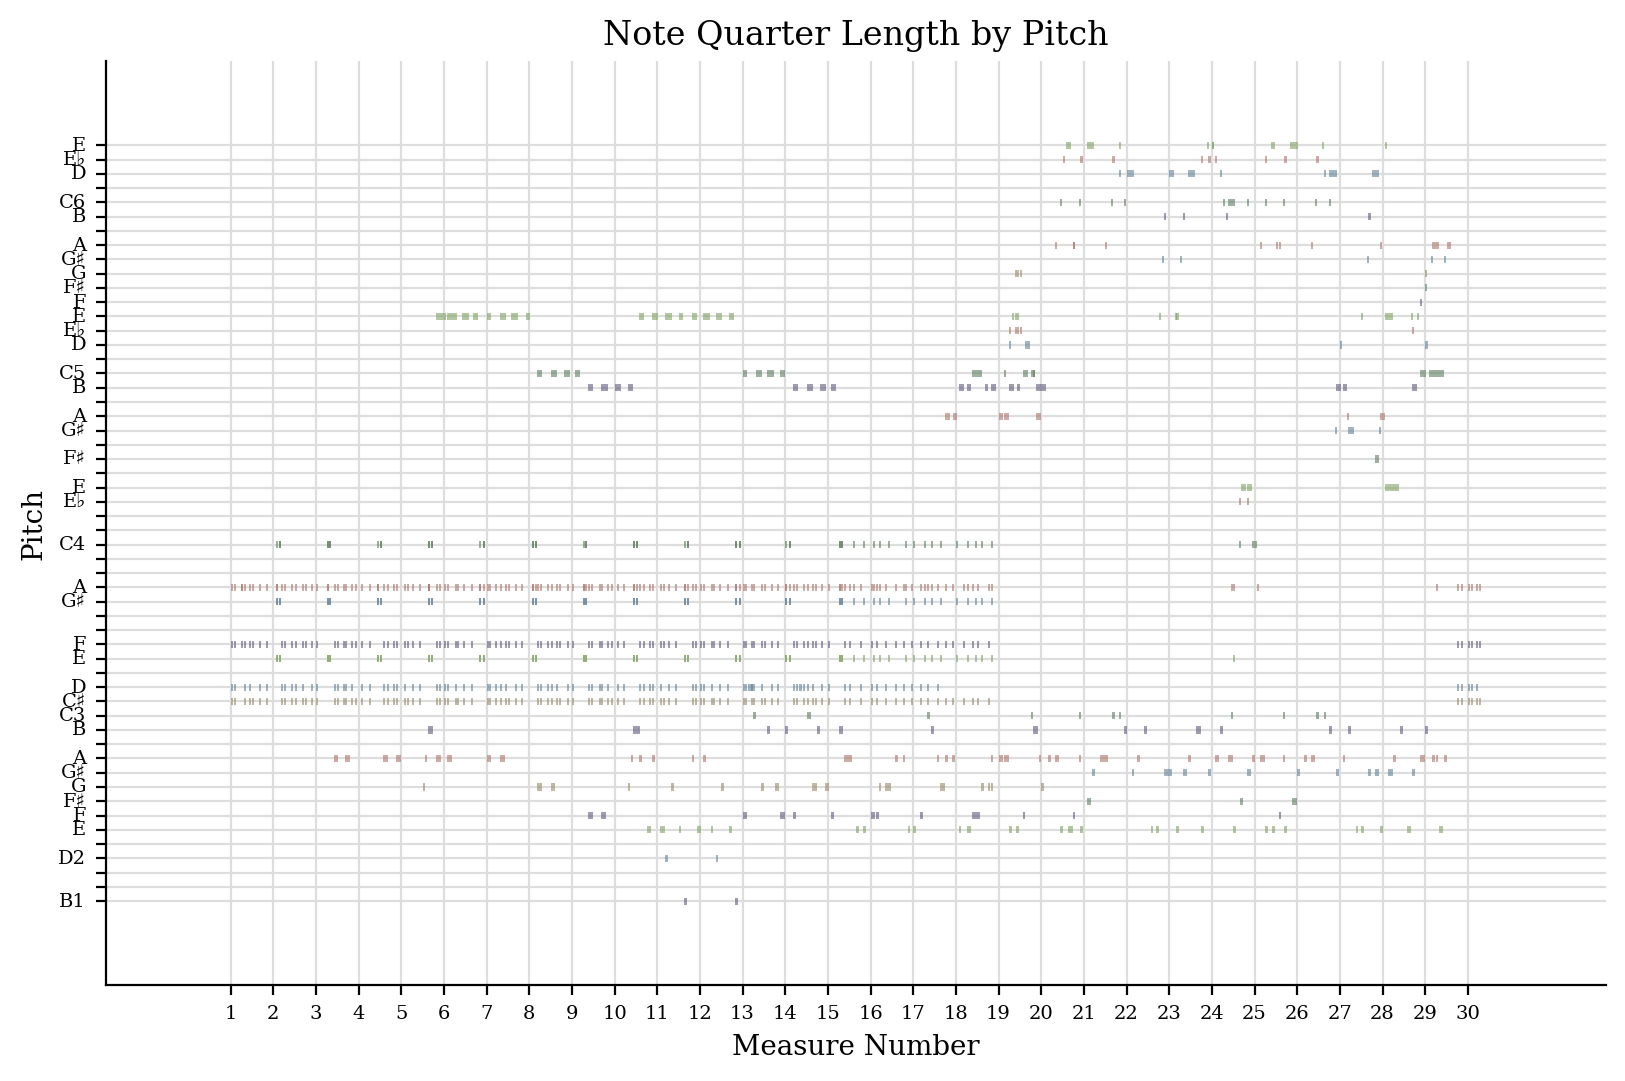

In [10]:
"""

    note quarted lenght by pitch

"""

aux.plot()

<music21.graph.plot.HistogramPitchClass for <music21.stream.Score 0x7f8c04a56c40>>

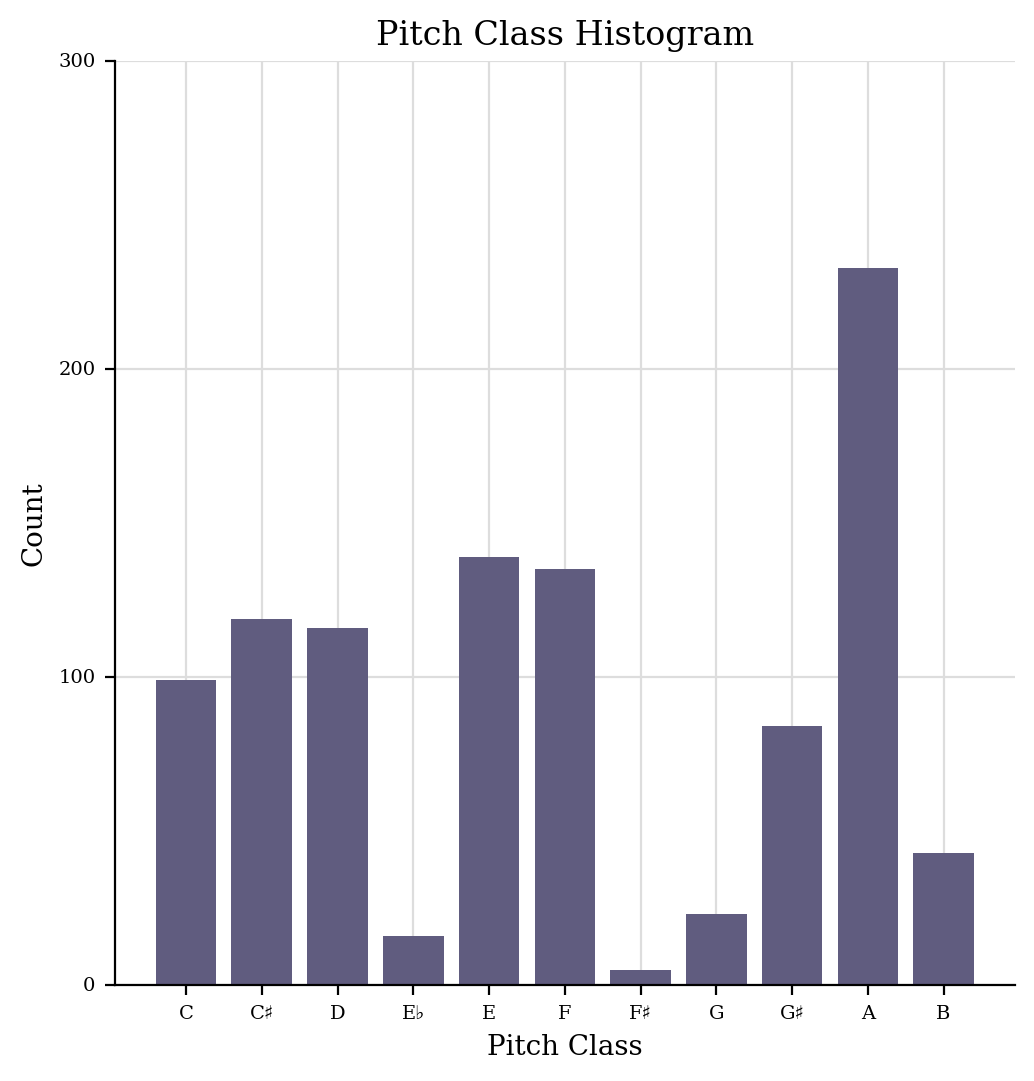

In [11]:
"""

    pitch class

"""

aux.plot('histogram', 'pitchClass')

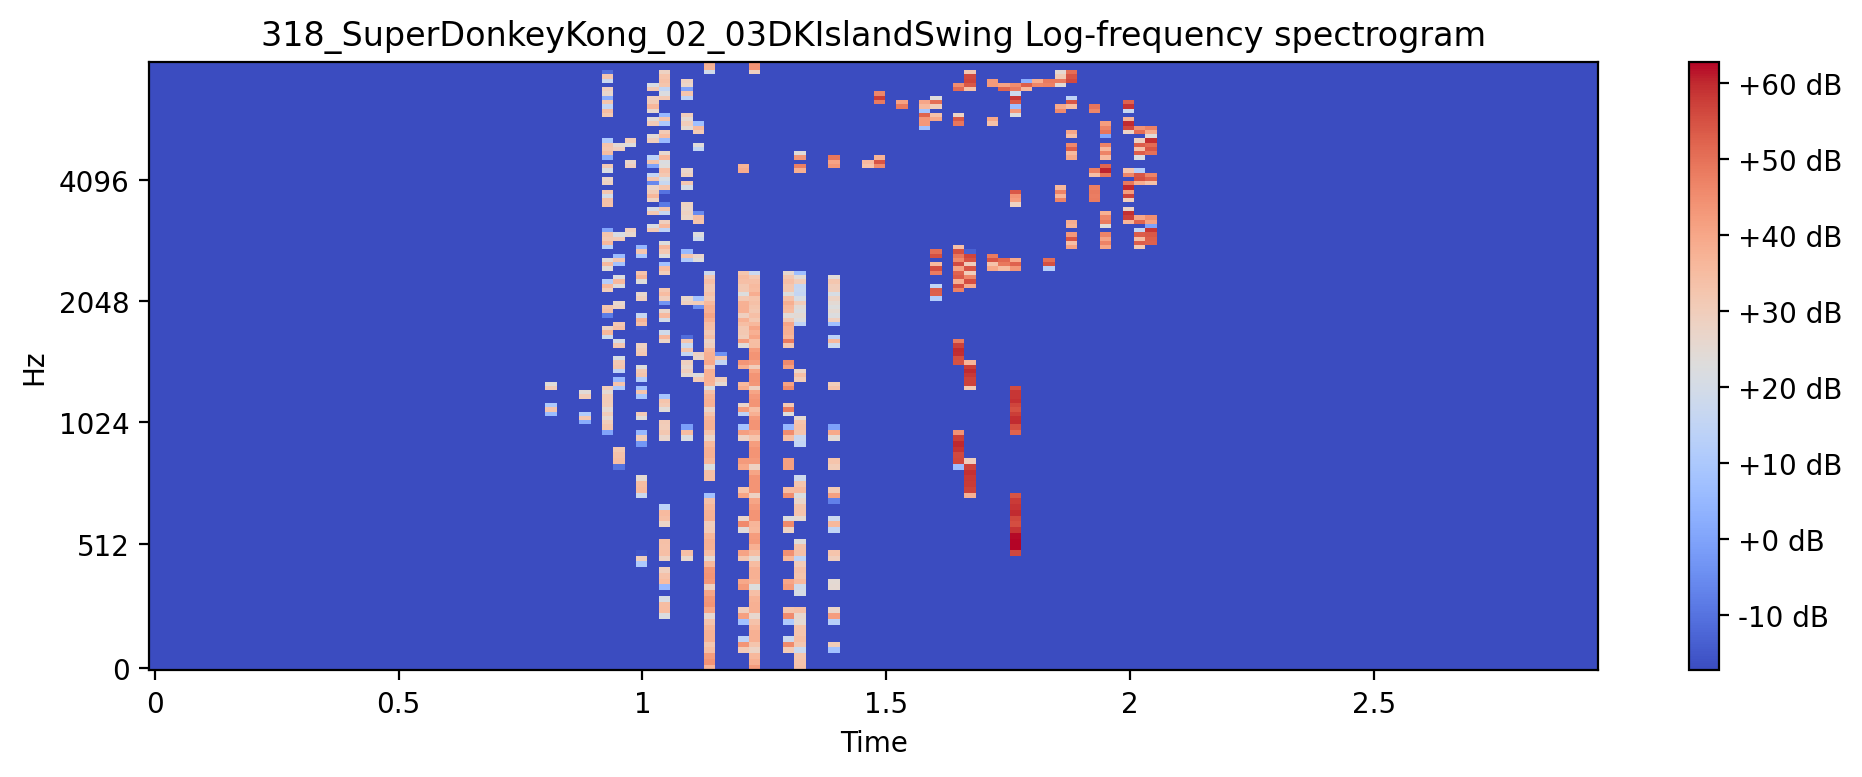

In [12]:
"""

    log-frequency spectogram

"""

aux_log_spec = librosa.amplitude_to_db(
            librosa.feature.melspectrogram(
                y=None, 
                sr=100, 
                S=midi[ sample ].T, 
                n_fft=2048, 
                hop_length=512, 
                power=2.0, 
                n_mels=128), 
            ref=1.0
        )

plt.figure(figsize=(10, 4))
librosa.display.specshow( aux_log_spec, y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title(f'{sample.replace(".mid", "")} Log-frequency spectrogram')
plt.tight_layout()
plt.show()

In [36]:
"""

    data loader

"""

class AudioDataset( Dataset ):
    
    def __init__(self, midi_files):
        
        self.midi_files = midi_files

    def __len__(self):
        
        return len( self.midi_files )

    def __getitem__( self, idx ):
        
        midi_file = self.midi_files[ idx ]
        
        # log-frequency spectogram
        log_spec = librosa.amplitude_to_db(
            librosa.feature.melspectrogram(
                y=None, 
                sr=100, 
                S=midi_file.T, 
                n_fft=1024, 
                hop_length=512, 
                power=2.0, 
                n_mels=128), 
            ref=1.0
        )
        
        # convert to pytorch tensor
        eps = 1e-38
        log_spec_db = torch.from_numpy( log_spec ).float()#.unsqueeze(0)  # add channel dimension
        log_spec_norm = ( log_spec_db - torch.min(log_spec_db) ) / ( torch.max(log_spec_db) - torch.min(log_spec_db) + eps)
        log_spec_norm = log_spec_norm.unsqueeze(0)

        return log_spec_norm
    
dataset = AudioDataset( list(midi.values()) )

dataloader = torch.utils.data.DataLoader(
    dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    drop_last=True
)

for i, spec_tensor in enumerate( dataloader ):
    
    print(f'batch {i}: {spec_tensor.size()}')
    print(f'batch variance: {spec_tensor.var()}')
    print(f'max, min: {spec_tensor.max()}, {spec_tensor.min()}')
    print('\n')

batch 0: torch.Size([100, 1, 128, 128])
batch variance: 0.02327955700457096
max, min: 1.0, 0.0


batch 1: torch.Size([100, 1, 128, 128])
batch variance: 0.02121630311012268
max, min: 1.0, 0.0


batch 2: torch.Size([100, 1, 128, 128])
batch variance: 0.020040880888700485
max, min: 1.0, 0.0




/Users/no_lineal/opt/anaconda3/envs/bitmusic38/lib/python3.8/site-packages/librosa/feature/spectral.py:2157: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


batch 3: torch.Size([100, 1, 128, 128])
batch variance: 0.020250406116247177
max, min: 1.0, 0.0


batch 4: torch.Size([100, 1, 128, 128])
batch variance: 0.02071196585893631
max, min: 1.0, 0.0


batch 5: torch.Size([100, 1, 128, 128])
batch variance: 0.0200361218303442
max, min: 1.0, 0.0


batch 6: torch.Size([100, 1, 128, 128])
batch variance: 0.022397076711058617
max, min: 1.0, 0.0


batch 7: torch.Size([100, 1, 128, 128])
batch variance: 0.022145243361592293
max, min: 1.0, 0.0


